El servicio de telefonía virtual CallMeMaybe está desarrollando una nueva función que brindará a los supervisores y las supervisores información sobre los operadores menos eficaces. Se considera que un operador es ineficaz si tiene una gran cantidad de llamadas entrantes perdidas (internas y externas) y un tiempo de espera prolongado para las llamadas entrantes. Además, si se supone que un operador debe realizar llamadas salientes, un número reducido de ellas también será un signo de ineficacia.

- Lleva a cabo el análisis exploratorio de datos
- Identificar operadores ineficaces
- Prueba las hipótesis estadísticas

In [22]:
import pandas as pd
import seaborn as sns
import numpy as np
from scipy.stats import mannwhitneyu
import matplotlib.pyplot as plt
from pathlib import Path

In [23]:
dataset= pd.read_csv('C:/Users/mitlalocelot/proyecto_final/telecom_dataset_us.csv')
clients=pd.read_csv('C:/Users/mitlalocelot/proyecto_final/telecom_clients_us.csv')

In [24]:
print(dataset[['calls_count', 'call_duration', 'total_call_duration']].describe())

        calls_count  call_duration  total_call_duration
count  53902.000000   53902.000000         53902.000000
mean      16.451245     866.684427          1157.133297
std       62.917170    3731.791202          4403.468763
min        1.000000       0.000000             0.000000
25%        1.000000       0.000000            47.000000
50%        4.000000      38.000000           210.000000
75%       12.000000     572.000000           902.000000
max     4817.000000  144395.000000        166155.000000


In [25]:
dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 53902 entries, 0 to 53901
Data columns (total 9 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   user_id              53902 non-null  int64  
 1   date                 53902 non-null  object 
 2   direction            53902 non-null  object 
 3   internal             53785 non-null  object 
 4   operator_id          45730 non-null  float64
 5   is_missed_call       53902 non-null  bool   
 6   calls_count          53902 non-null  int64  
 7   call_duration        53902 non-null  int64  
 8   total_call_duration  53902 non-null  int64  
dtypes: bool(1), float64(1), int64(4), object(3)
memory usage: 3.3+ MB


In [26]:
clients.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 732 entries, 0 to 731
Data columns (total 3 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   user_id      732 non-null    int64 
 1   tariff_plan  732 non-null    object
 2   date_start   732 non-null    object
dtypes: int64(1), object(2)
memory usage: 17.3+ KB


In [27]:
dataset['date'] = pd.to_datetime(dataset['date'])


valores ausentes

una vez cargado y explorado los datos buscan valores ausentes en los dataset 
Dataset telecom_dataset_us.csv:

Hay 53,902 filas.

Las columnas internal, operator_id tienen valores nulos.

No hay valores nulos en otras columnas, excepto en estas dos.


In [28]:
values=dataset.isnull().sum()
print(values)

user_id                   0
date                      0
direction                 0
internal                117
operator_id            8172
is_missed_call            0
calls_count               0
call_duration             0
total_call_duration       0
dtype: int64


In [29]:
internal_calls = dataset[dataset['internal'] == True]
non_internal_calls = dataset[dataset['internal'] == False]

print("Estadísticas de llamadas internas:")
print(internal_calls[['call_duration', 'total_call_duration', 'calls_count']].describe())

print("Estadísticas de llamadas no internas:")
print(non_internal_calls[['call_duration', 'total_call_duration', 'calls_count']].describe())

Estadísticas de llamadas internas:
       call_duration  total_call_duration  calls_count
count    6164.000000          6164.000000  6164.000000
mean      102.424400           125.279689     2.577547
std       250.311768           263.396054     2.931140
min         0.000000             0.000000     1.000000
25%         0.000000             9.000000     1.000000
50%         6.000000            34.000000     2.000000
75%        89.000000           116.000000     3.000000
max      5189.000000          5241.000000    83.000000
Estadísticas de llamadas no internas:
       call_duration  total_call_duration   calls_count
count   47621.000000         47621.000000  47621.000000
mean      967.587724          1293.341215     18.282543
std      3958.229562          4666.890521     66.714068
min         0.000000             0.000000      1.000000
25%         0.000000            61.000000      2.000000
50%        54.000000           269.000000      5.000000
75%       705.000000          1075.00000

Llamadas Internas:

Duración de las llamadas (call_duration):

La media es de 102.42 segundos, lo que sugiere que, en promedio, las llamadas internas son relativamente cortas. El 75% de las llamadas tienen una duración de menos de 89 segundos, pero hay algunas que alcanzan 5,189 segundos (aproximadamente 86 minutos)

El 75% de los operadores tienen 3 llamadas o menos, lo que también indica que la mayoría de los operadores no tienen un gran volumen de llamadas internas.

Llamadas No Internas:

Duración de las llamadas (call_duration):

La media es de 967.59 segundos, significativamente mayor que las llamadas internas, lo que sugiere que las llamadas no internas suelen ser mucho más largas.

La media es de 1,293.34 segundos, lo que es una indicación de que el tiempo de espera para las llamadas no internas es considerablemente más alto que para las internas.


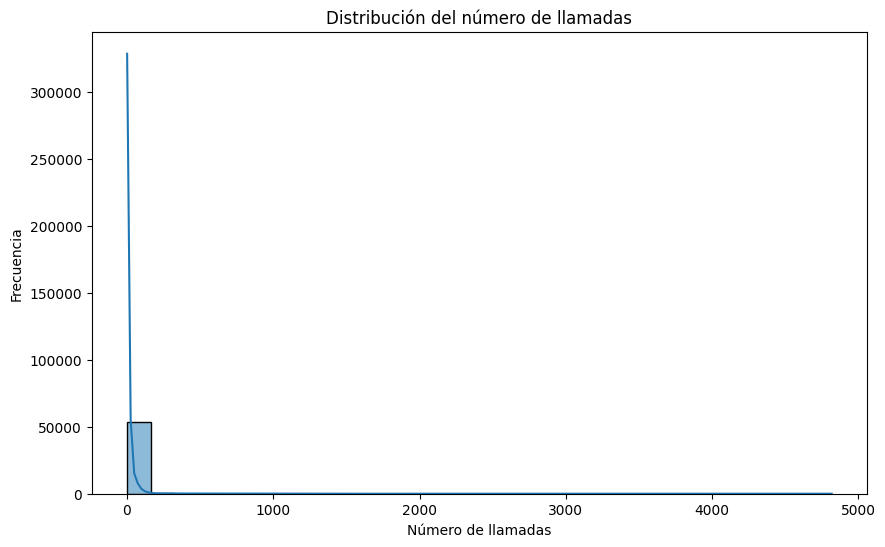

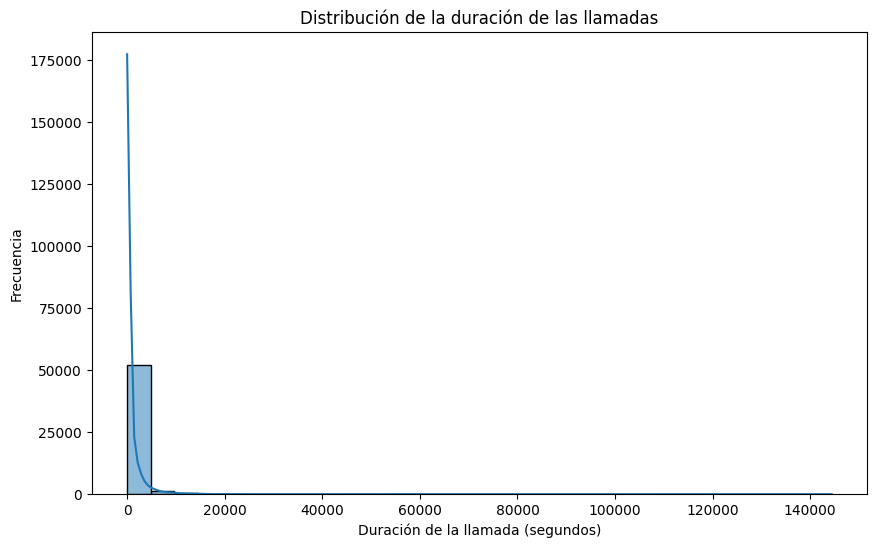

In [30]:
# distribucion del numero de llamadas 
plt.figure(figsize=(10,6))
sns.histplot(dataset['calls_count'], kde=True, bins=30)
plt.title('Distribución del número de llamadas')
plt.xlabel('Número de llamadas')
plt.ylabel('Frecuencia')
plt.show()

# Distribución de la duración de las llamadas
plt.figure(figsize=(10,6))
sns.histplot(dataset['call_duration'], kde=True, bins=30)
plt.title('Distribución de la duración de las llamadas')
plt.xlabel('Duración de la llamada (segundos)')
plt.ylabel('Frecuencia')
plt.show()

la Distribución del número de llamadas indica que la gran mayoría de datos corresponden a un número de llamadas muy bajo, probablemente cero o cercano a cero.

Al igual que la gráfica del número de llamadas, esta distribución de la duración de las llamadas está fuertemente sesgada hacia la izquierda.

Esta gráfica de la actividad de llamadas (en este caso, la duración) tiende a ser breve en la mayoría de los casos, con solo unas pocas llamadas que se extienden durante períodos de tiempo mucho más largos. 

Manejo de los valores nulos

Columna internal: Esta columna tiene 117 valores nulos, lo que podría deberse a que algunas llamadas no son internas (es decir, no se refiere a una comunicación dentro de la misma organización). Podemos considerar llenarlos con un valor como False (si no tenemos más contexto sobre si estas llamadas son internas o no).

Columna operator_id: Esta columna tiene 8,172 valores nulos, Los valores nulos podrían indicar que no se asignó un operador en algunas llamadas por lo que decimos excluirlas de nuestro analisis para asegurarnos de que solo analizamos llamadas con un operador asignado.

In [31]:
missing_internal_operator = dataset[dataset['internal'].isna() & dataset['operator_id'].isna()]

# Mostrar una muestra de estos registros
print(missing_internal_operator.head(20))

       user_id                      date direction internal  operator_id  \
1007    166405 2019-09-18 00:00:00+03:00        in      NaN          NaN   
1090    166405 2019-10-01 00:00:00+03:00        in      NaN          NaN   
1864    166406 2019-08-20 00:00:00+03:00        in      NaN          NaN   
7523    166604 2019-10-31 00:00:00+03:00        in      NaN          NaN   
15046   166884 2019-08-30 00:00:00+03:00        in      NaN          NaN   
15055   166884 2019-09-02 00:00:00+03:00        in      NaN          NaN   
15093   166884 2019-09-17 00:00:00+03:00        in      NaN          NaN   
15136   166884 2019-10-16 00:00:00+03:00        in      NaN          NaN   
20904   167011 2019-09-13 00:00:00+03:00        in      NaN          NaN   
21004   167016 2019-10-23 00:00:00+03:00       out      NaN          NaN   
24477   167110 2019-09-11 00:00:00+03:00        in      NaN          NaN   
24489   167110 2019-09-19 00:00:00+03:00        in      NaN          NaN   
24493   1671

In [32]:
dataset['internal'] = dataset['internal'].fillna(False)
dataset[dataset["operator_id"].isna()].head(20)
dataset_filtered = dataset[dataset['operator_id'].notna()]

C:\Users\mitlalocelot\AppData\Local\Temp\ipykernel_12140\1888613930.py:1: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  dataset['internal'] = dataset['internal'].fillna(False)


division de llamadas

dividimos las llamadas de la columna (DIRECTION) en IN Y OUT las agrupamos por operador_id y le agregamos el total de lllamadas perdidas,total de llamadas entrantes y tiempo de espera promedio para cada uno para posteriormente unirlo y formar un nuveo dataset con todas las columnas necesarias para identificar a los operadores ineficientes.


In [33]:
entrantes = dataset[dataset["direction"] == "in"]
operadores_entrantes = entrantes.groupby("operator_id").agg(
    llamadas_perdidas=("is_missed_call", "sum"),
    total_llamadas_entrantes=("calls_count", "sum"),
    tiempo_espera_prom=("total_call_duration", "mean")
).reset_index()

In [34]:
# Filtrar operadores salientes
salientes = dataset[dataset["direction"] == "out"]
operadores_salientes = salientes.groupby("operator_id").agg(
    llamadas_salientes=("calls_count", "sum"),
    duracion_promedio_salientes=("call_duration", "mean"),
    tiempo_total_promedio_salientes=("total_call_duration", "mean")
).reset_index()


In [35]:
# Unir datasets
operadores = operadores_entrantes.merge(operadores_salientes, on="operator_id", how="left").fillna(0)
operadores.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 754 entries, 0 to 753
Data columns (total 7 columns):
 #   Column                           Non-Null Count  Dtype  
---  ------                           --------------  -----  
 0   operator_id                      754 non-null    float64
 1   llamadas_perdidas                754 non-null    int64  
 2   total_llamadas_entrantes         754 non-null    int64  
 3   tiempo_espera_prom               754 non-null    float64
 4   llamadas_salientes               754 non-null    float64
 5   duracion_promedio_salientes      754 non-null    float64
 6   tiempo_total_promedio_salientes  754 non-null    float64
dtypes: float64(5), int64(2)
memory usage: 41.4 KB


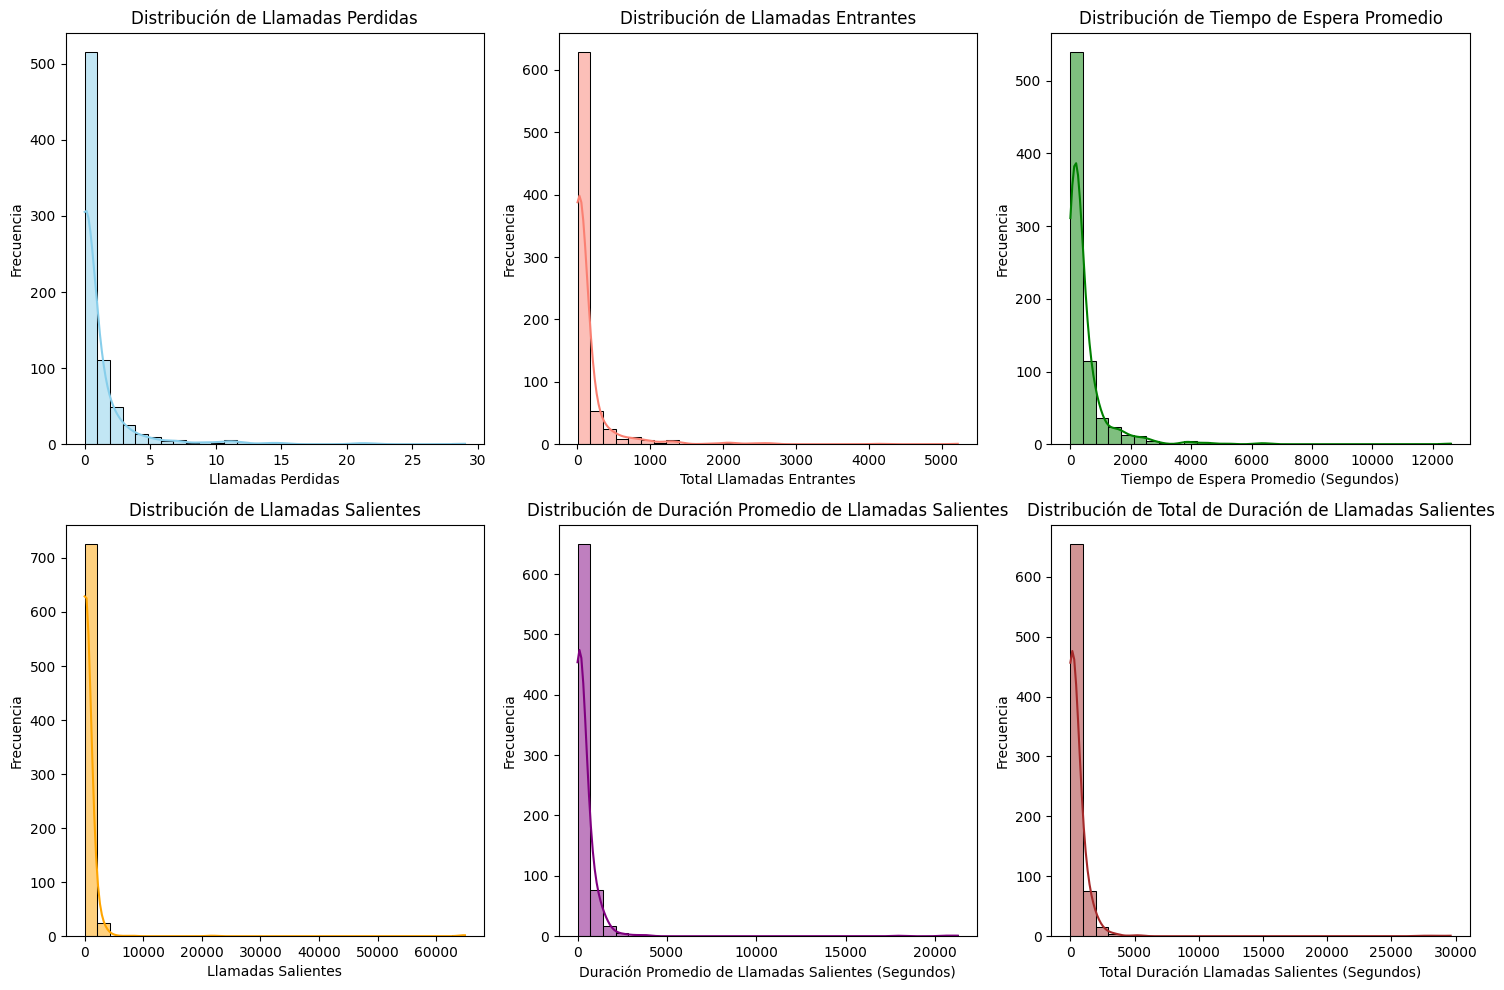

In [36]:
plt.figure(figsize=(15, 10))

# Histograma de llamadas perdidas por operador
plt.subplot(2, 3, 1)
sns.histplot(operadores['llamadas_perdidas'], kde=True, color='skyblue', bins=30)
plt.title('Distribución de Llamadas Perdidas')
plt.xlabel('Llamadas Perdidas')
plt.ylabel('Frecuencia')

# Histograma de total de llamadas entrantes
plt.subplot(2, 3, 2)
sns.histplot(operadores['total_llamadas_entrantes'], kde=True, color='salmon', bins=30)
plt.title('Distribución de Llamadas Entrantes')
plt.xlabel('Total Llamadas Entrantes')
plt.ylabel('Frecuencia')

# Histograma de tiempo de espera promedio
plt.subplot(2, 3, 3)
sns.histplot(operadores['tiempo_espera_prom'], kde=True, color='green', bins=30)
plt.title('Distribución de Tiempo de Espera Promedio')
plt.xlabel('Tiempo de Espera Promedio (Segundos)')
plt.ylabel('Frecuencia')

# Histograma de llamadas salientes
plt.subplot(2, 3, 4)
sns.histplot(operadores['llamadas_salientes'], kde=True, color='orange', bins=30)
plt.title('Distribución de Llamadas Salientes')
plt.xlabel('Llamadas Salientes')
plt.ylabel('Frecuencia')

# Histograma de duración promedio de las llamadas salientes
plt.subplot(2, 3, 5)
sns.histplot(operadores['duracion_promedio_salientes'], kde=True, color='purple', bins=30)
plt.title('Distribución de Duración Promedio de Llamadas Salientes')
plt.xlabel('Duración Promedio de Llamadas Salientes (Segundos)')
plt.ylabel('Frecuencia')

# Histograma de total de duración de llamadas salientes
plt.subplot(2, 3, 6)
sns.histplot(operadores['tiempo_total_promedio_salientes'], kde=True, color='brown', bins=30)
plt.title('Distribución de Total de Duración de Llamadas Salientes')
plt.xlabel('Total Duración Llamadas Salientes (Segundos)')
plt.ylabel('Frecuencia')

plt.tight_layout()
plt.show()

Distribución de Llamadas Perdidas:

La gran mayoría de los operadores tienen un número muy bajo de llamadas perdidas, concentrándose cerca de 0. La frecuencia disminuye rápidamente a medida que aumenta el número de llamadas perdidas.

Distribución de Llamadas Entrantes:

La mayoría de los operadores atienden un número relativamente bajo de llamadas entrantes, con una alta frecuencia cerca de valores pequeños

Distribución de Tiempo de Espera Promedio:

El tiempo de espera promedio para la mayoría de los operadores es bajo hay una cola que se extiende hacia tiempos de espera más largos, lo que indica que algunos operadores tienen un tiempo de espera promedio considerablemente mayor.

Distribución de Llamadas Salientes:

La mayoría de los operadores realizan un número relativamente bajo de llamadas salientes, con una alta frecuencia cerca de 0

Distribución de Duración Promedio de Llamadas Salientes:

Va de 0 a aproximadamente 20000 segundos.

La duración promedio de las llamadas salientes para la mayoría de los operadores es relativamente corta

Distribución de Total de Duración de Llamadas Salientes:

Hay una cola que se extiende hacia duraciones totales más largas, aunque estos casos son mucho menos comunes. La distribución está sesgada hacia la izquierda.

la mayoría de los operadores se concentran en valores bajos, con distribuciones fuertemente sesgadas hacia la izquierda.Esto sugiere que la mayoría de los operadores tienen una actividad relativamente baja en estas áreas, pero hay algunos operadores con una actividad significativamente mayor.


identificar a operadores ineficaces

Con base en las distribuciones visualizadas,crearemos umbrales dinámicos basados en percentiles . El percentil 95 para la tasa de llamadas perdidas se enfoca en los peores casos, y el percentil 90 para el tiempo de espera promedio también señala a un grupo significativo de operadores con un rendimiento inferior .

para identificar a los operadores ineficientes trabajaremos en nuestro nuevo dataset que contiene la informacion del personal y de llamadas entrantes y salientes basándose en una combinación de una alta tasa de llamadas perdidas, un tiempo de espera promedio prolongado y una baja actividad general (pocas llamadas salientes y pocas entrantes).

In [37]:
# Excluir operadores con bajo volumen de llamadas
operadores = operadores[(operadores["total_llamadas_entrantes"] >= 10) | (operadores["llamadas_salientes"] >= 5)]

# Umbrales dinámicos
umbral_llamadas_perdidas = operadores["llamadas_perdidas"] / operadores["total_llamadas_entrantes"]
umbral_llamadas_perdidas = umbral_llamadas_perdidas.quantile(0.95)  # Solo el peor 5%
umbral_tiempo_espera = operadores["tiempo_espera_prom"].quantile(0.90)

# Condiciones para operadores ineficaces
operadores["ineficaz"] = (
    (operadores["llamadas_perdidas"] / operadores["total_llamadas_entrantes"] > umbral_llamadas_perdidas) |
    (operadores["tiempo_espera_prom"] > umbral_tiempo_espera) |
    ((operadores["llamadas_salientes"] < 5) & (operadores["total_llamadas_entrantes"] < 50)))  # Solo castiga si tienen pocas entrantes


In [38]:
# Filtrar operadores ineficaces
operadores_ineficaces = operadores[operadores["ineficaz"]]

print(operadores_ineficaces)

     operator_id  llamadas_perdidas  total_llamadas_entrantes  \
9       882684.0                  4                       643   
10      882686.0                  5                       837   
16      884408.0                  3                        41   
23      886146.0                  0                         1   
24      886674.0                  0                        14   
..           ...                ...                       ...   
726     962902.0                  0                       244   
739     968520.0                  0                        10   
740     969272.0                  1                       225   
742     969294.0                  0                        84   
749     971102.0                  0                        78   

     tiempo_espera_prom  llamadas_salientes  duracion_promedio_salientes  \
9           2844.326923               721.0                   855.964602   
10          2362.408451              3094.0                  1474.4

datos sobre operadores ineficientes

al filtrar los operadores ineficentes podemos observar que tenemos 164 personas que podemos catalogar como ineficientes Esto sugiere que bajo condiciones de ineficacia se esta capturando operadores que tienen:

Una alta tasa de llamadas perdidas. Tiempos de espera promedio prolongados. Un bajo número de llamadas salientes combinado con un bajo número de llamadas entrantes.

aqui una breve descripcion de los primeros 4 operadores ineficientes:

Operador 882684.0: Tuvo 4 llamadas perdidas de un total de 643 entrantes y un tiempo de espera promedio alto (2844 segundos).

Operador 882686.0: Tuvo 5 llamadas perdidas de 837 entrantes y un tiempo de espera promedio también alto (2362 segundos).

Operador 884408.0: Tuvo 3 llamadas perdidas de solo 41 entrantes y un tiempo de espera promedio relativamente bajo (198 segundos), pero podría haber sido marcado como ineficaz por tener pocas llamadas salientes (25) y pocas entrantes (41). Operador 886146.0: Tuvo 0 llamadas perdidas de solo 1 entrante y un tiempo de espera promedio alto (1808 segundos), pero también tiene pocas llamadas salientes (51) y muy pocas entrantes (1).

Operador 886674.0: Tuvo 0 llamadas perdidas de 14 entrantes y un tiempo de espera muy bajo (34 segundos), pero tiene 0 llamadas salientes y pocas entrantes (14).

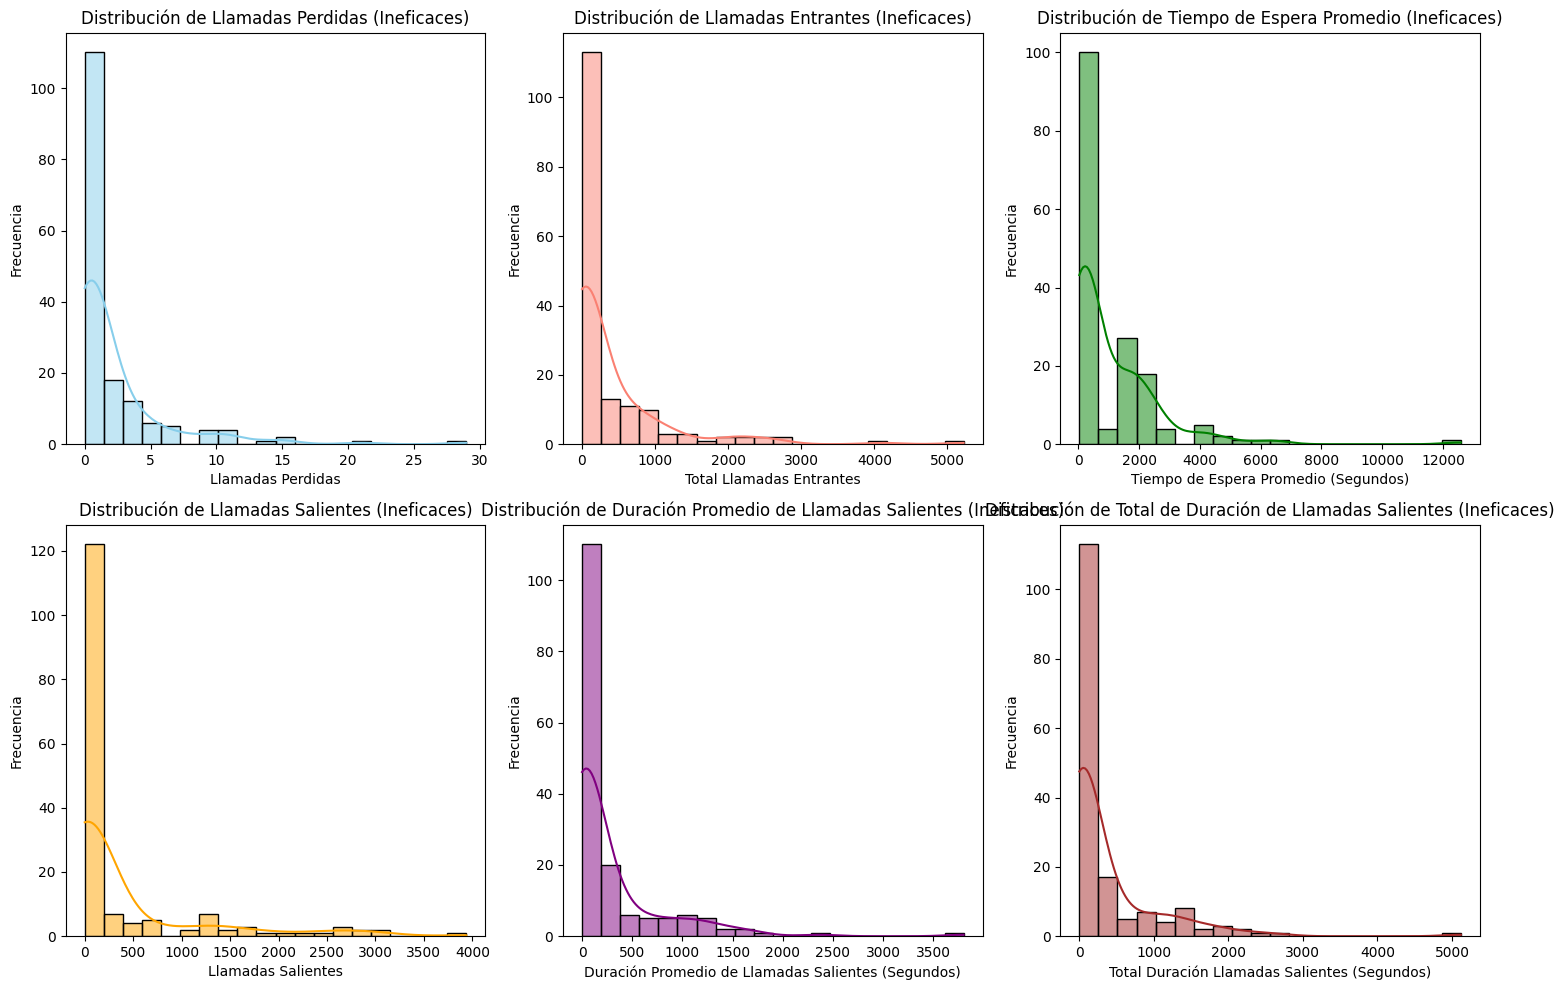

In [39]:
plt.figure(figsize=(15, 10))

# Histograma de llamadas perdidas
plt.subplot(2, 3, 1)
sns.histplot(operadores_ineficaces['llamadas_perdidas'], kde=True, color='skyblue', bins=20)
plt.title('Distribución de Llamadas Perdidas (Ineficaces)')
plt.xlabel('Llamadas Perdidas')
plt.ylabel('Frecuencia')

# Histograma de total de llamadas entrantes
plt.subplot(2, 3, 2)
sns.histplot(operadores_ineficaces['total_llamadas_entrantes'], kde=True, color='salmon', bins=20)
plt.title('Distribución de Llamadas Entrantes (Ineficaces)')
plt.xlabel('Total Llamadas Entrantes')
plt.ylabel('Frecuencia')

# Histograma de tiempo de espera promedio
plt.subplot(2, 3, 3)
sns.histplot(operadores_ineficaces['tiempo_espera_prom'], kde=True, color='green', bins=20)
plt.title('Distribución de Tiempo de Espera Promedio (Ineficaces)')
plt.xlabel('Tiempo de Espera Promedio (Segundos)')
plt.ylabel('Frecuencia')

# Histograma de llamadas salientes
plt.subplot(2, 3, 4)
sns.histplot(operadores_ineficaces['llamadas_salientes'], kde=True, color='orange', bins=20)
plt.title('Distribución de Llamadas Salientes (Ineficaces)')
plt.xlabel('Llamadas Salientes')
plt.ylabel('Frecuencia')

# Histograma de duración promedio de las llamadas salientes
plt.subplot(2, 3, 5)
sns.histplot(operadores_ineficaces['duracion_promedio_salientes'], kde=True, color='purple', bins=20)
plt.title('Distribución de Duración Promedio de Llamadas Salientes (Ineficaces)')
plt.xlabel('Duración Promedio de Llamadas Salientes (Segundos)')
plt.ylabel('Frecuencia')

# Histograma de total de duración de llamadas salientes
plt.subplot(2, 3, 6)
sns.histplot(operadores_ineficaces['tiempo_total_promedio_salientes'], kde=True, color='brown', bins=20)
plt.title('Distribución de Total de Duración de Llamadas Salientes (Ineficaces)')
plt.xlabel('Total Duración Llamadas Salientes (Segundos)')
plt.ylabel('Frecuencia')

plt.tight_layout()
plt.show()

Distribución de Llamadas Perdidas (Ineficaces): En comparación con la distribución general, la frecuencia de llamadas perdidas en el grupo de operadores ineficaces parece estar desplazada ligeramente hacia valores más altos.

Los operadores ineficaces tienden a tener, en promedio, un mayor número de llamadas perdidas que el conjunto de todos los operadores.

Distribución de Llamadas Entrantes (Ineficaces): Hay una mayor concentración de operadores ineficaces con un número bajo de llamadas entrantes (cerca de 0 y hasta unos pocos cientos). Los operadores ineficaces tienden a atender, en promedio, un menor número de llamadas entrantes que el resto de operadores.

Distribución de Tiempo de Espera Promedio (Ineficaces):

Comparación: La distribución del tiempo de espera promedio para los operadores ineficaces muestra claramente una mayor proporción de operadores con tiempos de espera promedio más altos en comparación con la distribución general. Los operadores ineficaces tienden a tener tiempos de espera promedio significativamente mayores que todos los operadores.

Distribución de Llamadas Salientes (Ineficaces): Los operadores ineficaces tienden a realizar muchas menos llamadas salientes que el conjunto de todos los operadores.

Distribución de Duración Promedio de Llamadas Salientes (Ineficaces):

Comparación: La distribución de la duración promedio de las llamadas salientes para los operadores ineficaces parece ser similar a la distribución general,

No hay tanta diferencia en la duración promedio de las llamadas salientes entre los operadores ineficaces y el conjunto general, aunque podría haber una ligera tendencia hacia llamadas más cortas en el grupo ineficaz.

Distribución de Total de Duración de Llamadas Salientes (Ineficaces):

La frecuencia de operadores con una duración total alta de llamadas salientes es mucho menor.

Los operadores ineficaces tienden a tener una duración total de llamadas salientes mucho menor



Tasa de llamadas perdidas: U=43285.5, p-value = 0.0000
 Diferencia significativa: los operadores ineficaces tienen una mayor tasa de llamadas perdidas.

Tiempo de espera promedio: U=41163.0, p-value = 0.0008
 Diferencia significativa: los operadores ineficaces tienen mayor tiempo de espera.

Llamadas salientes: U=22332.5, p-value = 0.0000
 Diferencia significativa: los operadores ineficaces hacen menos llamadas salientes.


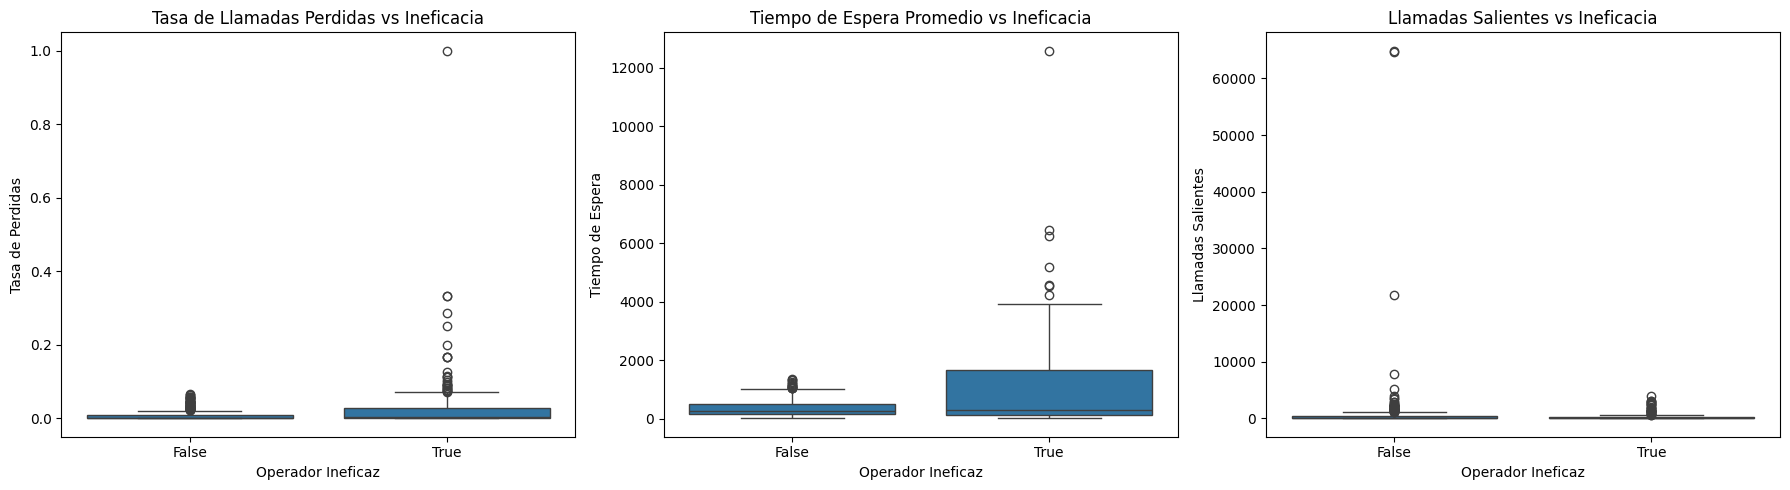

In [40]:
alfa = 0.05

# Separar grupos
group_ineficaz = operadores[operadores['ineficaz']]
group_eficaz = operadores[~operadores['ineficaz']]

# Verificar que ambos grupos tengan datos
if len(group_ineficaz) > 0 and len(group_eficaz) > 0:
    # Métricas
    tasa_perdidas_inef = (group_ineficaz['llamadas_perdidas'] / group_ineficaz['total_llamadas_entrantes']).fillna(0)
    tasa_perdidas_efic = (group_eficaz['llamadas_perdidas'] / group_eficaz['total_llamadas_entrantes']).fillna(0)

    tiempo_inef = group_ineficaz['tiempo_espera_prom'].fillna(0)
    tiempo_efic = group_eficaz['tiempo_espera_prom'].fillna(0)

    salientes_inef = group_ineficaz['llamadas_salientes'].fillna(0)
    salientes_efic = group_eficaz['llamadas_salientes'].fillna(0)

    # 1. Tasa de llamadas perdidas
    u1, p1 = mannwhitneyu(tasa_perdidas_inef, tasa_perdidas_efic, alternative='greater')
    print(f"\nTasa de llamadas perdidas: U={u1}, p-value = {p1:.4f}")
    if p1 < alfa:
        print(" Diferencia significativa: los operadores ineficaces tienen una mayor tasa de llamadas perdidas.")
    else:
        print("No hay diferencia significativa en la tasa de llamadas perdidas.")

    # 2. Tiempo de espera promedio
    u2, p2 = mannwhitneyu(tiempo_inef, tiempo_efic, alternative='greater')
    print(f"\nTiempo de espera promedio: U={u2}, p-value = {p2:.4f}")
    if p2 < alfa:
        print(" Diferencia significativa: los operadores ineficaces tienen mayor tiempo de espera.")
    else:
        print(" No hay diferencia significativa en el tiempo de espera promedio.")

    # 3. Llamadas salientes
    u3, p3 = mannwhitneyu(salientes_inef, salientes_efic, alternative='less')
    print(f"\nLlamadas salientes: U={u3}, p-value = {p3:.4f}")
    if p3 < alfa:
        print(" Diferencia significativa: los operadores ineficaces hacen menos llamadas salientes.")
    else:
        print("No hay diferencia significativa en las llamadas salientes.")

    # Gráficas
    plt.figure(figsize=(18, 5))

    # Boxplot: Tasa de llamadas perdidas
    plt.subplot(1, 3, 1)
    sns.boxplot(x='ineficaz', y=operadores['llamadas_perdidas'] / operadores['total_llamadas_entrantes'], data=operadores)
    plt.title('Tasa de Llamadas Perdidas vs Ineficacia')
    plt.xlabel('Operador Ineficaz')
    plt.ylabel('Tasa de Perdidas')

    # Boxplot: Tiempo de espera
    plt.subplot(1, 3, 2)
    sns.boxplot(x='ineficaz', y='tiempo_espera_prom', data=operadores)
    plt.title('Tiempo de Espera Promedio vs Ineficacia')
    plt.xlabel('Operador Ineficaz')
    plt.ylabel('Tiempo de Espera')

    # Boxplot: Llamadas salientes
    plt.subplot(1, 3, 3)
    sns.boxplot(x='ineficaz', y='llamadas_salientes', data=operadores)
    plt.title('Llamadas Salientes vs Ineficacia')
    plt.xlabel('Operador Ineficaz')
    plt.ylabel('Llamadas Salientes')

    plt.tight_layout()
    plt.show()

else:
    print(" Uno de los grupos no tiene suficientes datos para realizar la prueba estadística.")

Se llevaron a cabo pruebas estadísticas para determinar si existen diferencias significativas entre los grupos de operadores eficientes e ineficientes.

Se utilizó la prueba de Mann-Whitney U (no paramétrica), dado que las distribuciones de las variables no se ajustaban a una distribución normal. Las métricas comparadas fueron:

Tasa de llamadas perdidas

Tiempo promedio de espera

Cantidad de llamadas salientes

Los resultados fueron los siguientes (nivel de significancia α = 0.05):

Tasa de llamadas perdidas: p < 0.05 → diferencia significativa.

Tiempo de espera promedio: p < 0.05 → diferencia significativa.

Llamadas salientes: p < 0.05 → diferencia significativa.

Estos resultados indican que los operadores clasificados como ineficaces presentan un desempeño estadísticamente menor al del resto en las variables mencionadas

Gráfica 1: Tasa de Llamadas Perdidas vs Ineficacia

Los operadores ineficaces tienden a tener una tasa de llamadas perdidas más alta que los operadores eficaces. La caja para el grupo "True" está generalmente más alta en el eje Y, y su mediana (línea naranja dentro de la caja) también es superior.

Gráfica 2: Tiempo de Espera Promedio vs Ineficacia

Los operadores ineficaces tienen un tiempo de espera promedio considerablemente mayor que los operadores eficaces.Los operadores ineficaces también presentan valores atípicos con tiempos de espera promedio extremadamente altos.

Gráfica 3: Llamadas Salientes vs Ineficacia

Los operadores ineficaces tienden a realizar menos llamadas salientes que los operadores eficaces La dispersión del número de llamadas salientes parece ser mayor para los operadores eficaces.

Los operadores ineficaces tienen una mayor tasa de llamadas perdidas y un mayor tiempo de espera promedio. Los operadores ineficaces tienden a realizar menos llamadas salientes.
